Running Model-918: 4500it [00:01, 3101.29it/s]<?, ?it/s]
Running Model-918: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Fitting node Ridge-918...


Running Model-918: 490it [00:00, 3062.48it/s]           


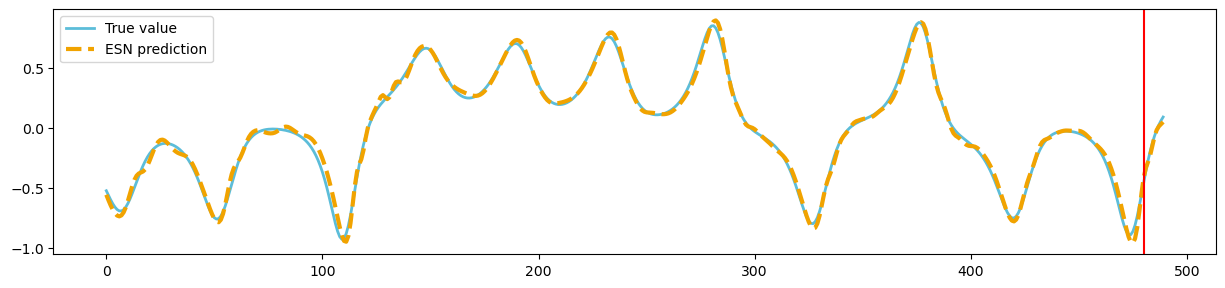

In [125]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import math
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4500
forecast = 10

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data

dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]

#000
x1 = data.lorenz(length=6500, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x1) 
X1 = time[:,0] 
X1 = X1.reshape(6500,1) 
X1 = 2 * (X1 - X1.min()) / (X1.max() - X1.min()) - 1 
#000
    
X = X1[:5000]


def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3 #коэффициент утечки от 0 до 1
spectral_radius = 1.25 #от 0.1 до 1
input_scaling = 1.0
connectivity = 1.0 #от 0 до 1
input_connectivity = 0.2 #тоже %
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
###HERE1

In [103]:
Units = np.arange(30, 1000, 400)
Units.shape

(3,)

In [104]:
Leak_rate = np.arange(0.05, 1.0, 0.5)
Leak_rate.shape

(2,)

In [105]:
Spectral_radius = np.arange(0.1, 1.0, 0.5)
Spectral_radius.shape

(2,)

In [106]:
Input_scaling = np.arange(1.0, 5.0, 2.0)
Input_scaling.shape

(2,)

In [107]:
Connectivity = np.arange(0.01, 1.0, 0.5)
Connectivity.shape

(2,)

In [108]:
Input_connectivity = np.arange(0.01, 1.0, 0.5)
Input_connectivity.shape

(2,)

In [109]:
Regularization = np.arange(1e-8, 1.0, 0.5)
Regularization.shape

(2,)

In [110]:
Seed = np.arange(1234, 1734, 300)
Seed.shape

(2,)

In [111]:
def rmse(x_test, x_sim):
        res = 0
        for i in range(len(x_sim)):
            res = res + (x_sim[i] - x_test[i])**2
        res = math.sqrt(res/len(x_sim))
        return res

In [112]:
rmse(y_pred1[-100:], X[-100:])

C:\Users\nicks\AppData\Local\Temp\ipykernel_22264\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


0.06389742597208328

In [113]:
BestRmse = 0.06389742597208328
BestHyp = np.empty((8, 1))

BestHyp[0] = 100
BestHyp[1] = 0.3
BestHyp[2] = 1.25
BestHyp[3] = 1.0
BestHyp[4] = 1.0
BestHyp[5] = 0.2
BestHyp[6] = 1e-8
BestHyp[7] = 1234

In [114]:
BestHyp[7] 

array([1234.])

In [115]:
for q in range(len(Units)):
    for w in range(len(Leak_rate)):
        for e in range(len(Spectral_radius)):
            for r in range(len(Input_scaling)):
                for t in range(len(Connectivity)):
                    for z in range(len(Input_connectivity)):
                        for u in range(len(Regularization)):
                            for a in range(len(Seed)):
                                #Первый тестовый набор параметров 
                                units = Units[q]
                                leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                spectral_radius = Spectral_radius[e] #от 0.1 до 1
                                input_scaling = Input_scaling[r]
                                connectivity = Connectivity[t] #от 0 до 1
                                input_connectivity = Input_connectivity[z] #тоже %
                                regularization = Regularization[u]
                                seed = Seed[a]

                                #узел резервуара
                                reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                    lr=leak_rate, rc_connectivity=connectivity,
                                                    input_connectivity=input_connectivity, seed=seed)
                                #выходной слой(считывающее устройство)
                                readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                #соединяем узлы и таким образом получаем модель 
                                esn = reservoir >> readout

                                #обучение модели
                                esn = esn.fit(X_train1, y_train1)
                                #делаем предсказание
                                y_pred1 = esn.run(X_test1, reset=False)
                                #results(y_pred1, X[train+forecast:])
                                Rmse = rmse(y_pred1[-100:], X[-100:])
                                if (Rmse<BestRmse):
                                    BestRmse = Rmse
                                    BestHyp[0] = Units[q]
                                    BestHyp[1] = Leak_rate[w]
                                    BestHyp[2] = Spectral_radius[e]
                                    BestHyp[3] = Input_scaling[r]
                                    BestHyp[4] = Connectivity[t]
                                    BestHyp[5] = Input_connectivity[z]
                                    BestHyp[6] = Regularization[u]
                                    BestHyp[7] = Seed[a]


Running Model-529:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-529: 4500it [00:00, 8064.33it/s]
Running Model-529: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-529...


Running Model-529: 490it [00:00, 8750.78it/s]           
C:\Users\nicks\AppData\Local\Temp\ipykernel_22264\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))
Running Model-530: 4500it [00:00, 7839.64it/s]<?, ?it/s]
Running Model-530: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-530...


Running Model-530: 490it [00:00, 7314.22it/s]           
Running Model-531: 4500it [00:00, 7588.23it/s]<?, ?it/s]
Running Model-531: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-531...


Running Model-531: 490it [00:00, 8596.32it/s]           
Running Model-532: 4500it [00:00, 8318.00it/s]<?, ?it/s]
Running Model-532: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Fitting node Ridge-532...


Running Model-532: 490it [00:00, 8032.46it/s]           
Running Model-533: 4500it [00:00, 8108.11it/s]<?, ?it/s]
Running Model-533: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-533...


Running Model-533: 490it [00:00, 8304.48it/s]           
Running Model-534: 4500it [00:00, 8620.57it/s]<?, ?it/s]
Running Model-534: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-534...


Running Model-534: 490it [00:00, 8594.63it/s]           
Running Model-535: 4500it [00:00, 8256.80it/s]<?, ?it/s]
Running Model-535: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-535...


Running Model-535: 490it [00:00, 8881.48it/s]           
Running Model-536: 4500it [00:00, 8256.57it/s]<?, ?it/s]
Running Model-536: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-536...


Running Model-536: 490it [00:00, 8304.78it/s]           
Running Model-537: 4500it [00:00, 8151.90it/s]<?, ?it/s]
Running Model-537: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-537...


Running Model-537: 490it [00:00, 9054.26it/s]           
Running Model-538: 4500it [00:00, 8050.22it/s]<?, ?it/s]
Running Model-538: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-538...


Running Model-538: 490it [00:00, 8909.50it/s]           
Running Model-539: 4500it [00:00, 8555.17it/s]<?, ?it/s]
Running Model-539: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-539...


Running Model-539: 490it [00:00, 7656.12it/s]           
Running Model-540: 4500it [00:00, 8490.60it/s]<?, ?it/s]
Running Model-540: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-540...


Running Model-540: 490it [00:00, 9074.53it/s]           
Running Model-541: 4500it [00:00, 8050.10it/s]<?, ?it/s]
Running Model-541: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-541...


Running Model-541: 490it [00:00, 8750.49it/s]           
Running Model-542: 4500it [00:00, 7894.88it/s]<?, ?it/s]
Running Model-542: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-542...


Running Model-542: 490it [00:00, 8750.19it/s]           
Running Model-543: 4500it [00:00, 8426.94it/s]<?, ?it/s]
Running Model-543: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-543...


Running Model-543: 490it [00:00, 6807.22it/s]           
Running Model-544: 4500it [00:00, 7812.57it/s]<?, ?it/s]
Running Model-544: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-544...


Running Model-544: 490it [00:00, 7902.92it/s]           
Running Model-545: 4500it [00:00, 8166.99it/s]<?, ?it/s]
Running Model-545: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-545...


Running Model-545: 490it [00:00, 9070.85it/s]           
Running Model-546: 4500it [00:00, 8226.65it/s]<?, ?it/s]
Running Model-546: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-546...


Running Model-546: 490it [00:00, 8750.08it/s]           
Running Model-547: 4500it [00:00, 8340.86it/s]<?, ?it/s]
Running Model-547: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-547...


Running Model-547: 490it [00:00, 8031.99it/s]           
Running Model-548: 4500it [00:00, 8256.98it/s]<?, ?it/s]
Running Model-548: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-548...


Running Model-548: 490it [00:00, 9072.45it/s]           
Running Model-549: 4500it [00:00, 8241.79it/s]<?, ?it/s]
Running Model-549: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-549...


Running Model-549: 490it [00:00, 7656.66it/s]           
Running Model-550: 4500it [00:00, 8458.27it/s]<?, ?it/s]
Running Model-550: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-550...


Running Model-550: 490it [00:00, 8908.96it/s]           
Running Model-551: 4500it [00:00, 8522.62it/s]<?, ?it/s]
Running Model-551: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-551...


Running Model-551: 490it [00:00, 8594.17it/s]           
Running Model-552: 4500it [00:00, 8620.55it/s]<?, ?it/s]
Running Model-552: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-552...


Running Model-552: 490it [00:00, 5833.51it/s]           
Running Model-553: 4500it [00:00, 7462.60it/s]<?, ?it/s]
Running Model-553: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-553...


Running Model-553: 490it [00:00, 8592.51it/s]           
Running Model-554: 4500it [00:00, 7908.70it/s]<?, ?it/s]
Running Model-554: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Fitting node Ridge-554...


Running Model-554: 490it [00:00, 7538.87it/s]           
Running Model-555: 4500it [00:00, 7614.19it/s]<?, ?it/s]
Running Model-555: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-555...


Running Model-555: 490it [00:00, 6203.73it/s]           
Running Model-556: 4500it [00:00, 8181.43it/s]<?, ?it/s]
Running Model-556: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-556...


Running Model-556: 490it [00:00, 8906.65it/s]           
Running Model-557: 4500it [00:00, 8256.89it/s]<?, ?it/s]
Running Model-557: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-557...


Running Model-557: 490it [00:00, 8425.85it/s]           
Running Model-558: 4500it [00:00, 8506.51it/s]<?, ?it/s]
Running Model-558: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-558...


Running Model-558: 490it [00:00, 6531.48it/s]           
Running Model-559: 4500it [00:00, 8522.84it/s]<?, ?it/s]
Running Model-559: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-559...


Running Model-559: 490it [00:00, 7904.50it/s]           
Running Model-560: 4500it [00:00, 8122.78it/s]<?, ?it/s]
Running Model-560: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-560...


Running Model-560: 490it [00:00, 7422.34it/s]           
Running Model-561: 4500it [00:00, 8538.79it/s]<?, ?it/s]
Running Model-561: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-561...


Running Model-561: 490it [00:00, 6712.03it/s]           
Running Model-562: 4500it [00:00, 8571.38it/s]<?, ?it/s]
Running Model-562: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-562...


Running Model-562: 490it [00:00, 8750.30it/s]           
Running Model-563: 4500it [00:00, 8587.58it/s]<?, ?it/s]
Running Model-563: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-563...


Running Model-563: 490it [00:00, 8594.02it/s]           
Running Model-564: 4500it [00:00, 8442.72it/s]<?, ?it/s]
Running Model-564: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-564...


Running Model-564: 490it [00:00, 6533.62it/s]           
Running Model-565: 4500it [00:00, 8137.21it/s]<?, ?it/s]
Running Model-565: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-565...


Running Model-565: 490it [00:00, 8745.68it/s]           
Running Model-566: 4500it [00:00, 8302.50it/s]<?, ?it/s]
Running Model-566: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-566...


Running Model-566: 490it [00:00, 8302.67it/s]           
Running Model-567: 4500it [00:00, 8211.75it/s]<?, ?it/s]
Running Model-567: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-567...


Running Model-567: 490it [00:00, 5384.46it/s]           
Running Model-568: 4500it [00:00, 7832.27it/s]<?, ?it/s]
Running Model-568: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-568...


Running Model-568: 490it [00:00, 8748.47it/s]           
Running Model-569: 4500it [00:00, 8286.98it/s]<?, ?it/s]
Running Model-569: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Fitting node Ridge-569...


Running Model-569: 490it [00:00, 8904.60it/s]           
Running Model-570: 4500it [00:00, 8211.42it/s]<?, ?it/s]
Running Model-570: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-570...


Running Model-570: 490it [00:00, 6532.29it/s]           
Running Model-571: 4500it [00:00, 8137.20it/s]<?, ?it/s]
Running Model-571: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-571...


Running Model-571: 490it [00:00, 8598.95it/s]           
Running Model-572: 4500it [00:00, 8620.67it/s]<?, ?it/s]
Running Model-572: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-572...


Running Model-572: 490it [00:00, 8302.03it/s]           
Running Model-573: 4500it [00:00, 8379.80it/s]<?, ?it/s]
Running Model-573: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-573...


Running Model-573: 490it [00:00, 6533.74it/s]           
Running Model-574: 4500it [00:00, 8442.34it/s]<?, ?it/s]
Running Model-574: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-574...


Running Model-574: 490it [00:00, 8593.52it/s]           
Running Model-575: 4500it [00:00, 8687.17it/s]<?, ?it/s]
Running Model-575: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-575...


Running Model-575: 490it [00:00, 9070.97it/s]           
Running Model-576: 4500it [00:00, 8379.74it/s]<?, ?it/s]
Running Model-576: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-576...


Running Model-576: 490it [00:00, 9071.65it/s]           
Running Model-577: 4500it [00:00, 8587.37it/s]<?, ?it/s]
Running Model-577: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-577...


Running Model-577: 490it [00:00, 7901.98it/s]           
Running Model-578: 4500it [00:00, 8554.78it/s]<?, ?it/s]
Running Model-578: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-578...


Running Model-578: 490it [00:00, 8443.96it/s]           
Running Model-579: 4500it [00:00, 8554.69it/s]<?, ?it/s]
Running Model-579: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-579...


Running Model-579: 490it [00:00, 6806.18it/s]           
Running Model-580: 4500it [00:00, 8823.42it/s]<?, ?it/s]
Running Model-580: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Fitting node Ridge-580...


Running Model-580: 490it [00:00, 8904.95it/s]           
Running Model-581: 4500it [00:00, 8687.26it/s]<?, ?it/s]
Running Model-581: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-581...


Running Model-581: 490it [00:00, 8749.11it/s]           
Running Model-582: 4500it [00:00, 8458.65it/s]<?, ?it/s]
Running Model-582: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-582...


Running Model-582: 490it [00:00, 6622.98it/s]           
Running Model-583: 4500it [00:00, 8823.14it/s]<?, ?it/s]
Running Model-583: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Fitting node Ridge-583...


Running Model-583: 490it [00:00, 9030.67it/s]           
Running Model-584: 4500it [00:00, 8720.93it/s]<?, ?it/s]
Running Model-584: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-584...


Running Model-584: 490it [00:00, 8908.66it/s]           
Running Model-585: 4500it [00:00, 8538.88it/s]<?, ?it/s]
Running Model-585: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-585...


Running Model-585: 490it [00:00, 8596.00it/s]           
Running Model-586: 4500it [00:00, 8093.40it/s]<?, ?it/s]
Running Model-586: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Fitting node Ridge-586...


Running Model-586: 490it [00:00, 8595.82it/s]           
Running Model-587: 4500it [00:00, 8158.14it/s]<?, ?it/s]
Running Model-587: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-587...


Running Model-587: 490it [00:00, 7776.22it/s]           
Running Model-588: 4500it [00:00, 8226.62it/s]<?, ?it/s]
Running Model-588: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-588...


Running Model-588: 490it [00:00, 6283.24it/s]           
Running Model-589: 4500it [00:00, 7824.77it/s]<?, ?it/s]
Running Model-589: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-589...


Running Model-589: 490it [00:00, 8746.39it/s]           
Running Model-590: 4500it [00:00, 8442.78it/s]<?, ?it/s]
Running Model-590: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-590...


Running Model-590: 490it [00:00, 8447.50it/s]           
Running Model-591: 4500it [00:00, 8506.59it/s]<?, ?it/s]
Running Model-591: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-591...


Running Model-591: 490it [00:00, 6446.74it/s]           
Running Model-592: 4500it [00:00, 8195.80it/s]<?, ?it/s]
Running Model-592: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-592...


Running Model-592: 490it [00:00, 9074.65it/s]           
Running Model-593: 4500it [00:00, 8554.98it/s]<?, ?it/s]
Running Model-593: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-593...


Running Model-593: 490it [00:00, 7536.11it/s]           
Running Model-594: 4500it [00:00, 8333.22it/s]<?, ?it/s]
Running Model-594: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-594...


Running Model-594: 490it [00:00, 8908.46it/s]           
Running Model-595: 4500it [00:00, 8137.44it/s]<?, ?it/s]
Running Model-595: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-595...


Running Model-595: 490it [00:00, 9077.42it/s]           
Running Model-596: 4500it [00:00, 8520.77it/s]<?, ?it/s]
Running Model-596: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-596...


Running Model-596: 490it [00:00, 9071.09it/s]           
Running Model-597: 4500it [00:00, 8226.63it/s]<?, ?it/s]
Running Model-597: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-597...


Running Model-597: 490it [00:00, 9072.81it/s]           
Running Model-598: 4500it [00:00, 8196.40it/s]<?, ?it/s]
Running Model-598: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Fitting node Ridge-598...


Running Model-598: 490it [00:00, 6620.97it/s]           
Running Model-599: 4500it [00:00, 7950.28it/s]<?, ?it/s]
Running Model-599: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-599...


Running Model-599: 490it [00:00, 8304.51it/s]           
Running Model-600: 4500it [00:00, 7389.08it/s]<?, ?it/s]
Running Model-600: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-600...


Running Model-600: 490it [00:00, 9074.17it/s]           
Running Model-601: 4500it [00:00, 8426.87it/s]<?, ?it/s]
Running Model-601: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-601...


Running Model-601: 490it [00:00, 9073.97it/s]           
Running Model-602: 4500it [00:00, 7652.73it/s]<?, ?it/s]
Running Model-602: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-602...


Running Model-602: 490it [00:00, 9075.57it/s]           
Running Model-603: 4500it [00:00, 8122.34it/s]<?, ?it/s]
Running Model-603: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-603...


Running Model-603: 490it [00:00, 8595.21it/s]           
Running Model-604: 4500it [00:00, 8442.64it/s]<?, ?it/s]
Running Model-604: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-604...


Running Model-604: 490it [00:00, 8446.04it/s]           
Running Model-605: 4500it [00:00, 8226.69it/s]<?, ?it/s]
Running Model-605: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-605...


Running Model-605: 490it [00:00, 8448.37it/s]           
Running Model-606: 4500it [00:00, 7992.93it/s]<?, ?it/s]
Running Model-606: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-606...


Running Model-606: 490it [00:00, 8749.07it/s]           
Running Model-607: 4500it [00:00, 8093.58it/s]<?, ?it/s]
Running Model-607: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-607...


Running Model-607: 490it [00:00, 8031.20it/s]           
Running Model-608: 4500it [00:00, 8226.75it/s]<?, ?it/s]
Running Model-608: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-608...


Running Model-608: 490it [00:00, 8908.00it/s]           
Running Model-609: 4500it [00:00, 7745.11it/s]<?, ?it/s]
Running Model-609: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-609...


Running Model-609: 490it [00:00, 9071.73it/s]           
Running Model-610: 4500it [00:00, 8136.11it/s]<?, ?it/s]
Running Model-610: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-610...


Running Model-610: 490it [00:00, 9073.33it/s]           
Running Model-611: 4500it [00:00, 8348.69it/s]<?, ?it/s]
Running Model-611: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-611...


Running Model-611: 490it [00:00, 7423.73it/s]           
Running Model-612: 4500it [00:00, 8364.36it/s]<?, ?it/s]
Running Model-612: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-612...


Running Model-612: 490it [00:00, 8597.73it/s]           
Running Model-613: 4500it [00:00, 8395.34it/s]<?, ?it/s]
Running Model-613: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-613...


Running Model-613: 490it [00:00, 7421.59it/s]           
Running Model-614: 4500it [00:00, 8442.72it/s]<?, ?it/s]
Running Model-614: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-614...


Running Model-614: 490it [00:00, 6049.09it/s]           
Running Model-615: 4500it [00:00, 8226.74it/s]<?, ?it/s]
Running Model-615: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-615...


Running Model-615: 490it [00:00, 8745.90it/s]           
Running Model-616: 4500it [00:00, 8687.16it/s]<?, ?it/s]
Running Model-616: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-616...


Running Model-616: 490it [00:00, 8905.57it/s]           
Running Model-617: 4500it [00:00, 8272.04it/s]<?, ?it/s]
Running Model-617: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Fitting node Ridge-617...


Running Model-617: 490it [00:00, 8907.92it/s]           
Running Model-618: 4500it [00:00, 8035.44it/s]<?, ?it/s]
Running Model-618: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-618...


Running Model-618: 490it [00:00, 9074.57it/s]           
Running Model-619: 4500it [00:00, 8603.76it/s]<?, ?it/s]
Running Model-619: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-619...


Running Model-619: 490it [00:00, 8302.16it/s]           
Running Model-620: 4500it [00:00, 8364.10it/s]<?, ?it/s]
Running Model-620: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-620...


Running Model-620: 490it [00:00, 9239.30it/s]           
Running Model-621: 4500it [00:00, 7978.46it/s]<?, ?it/s]
Running Model-621: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-621...


Running Model-621: 490it [00:00, 8909.20it/s]           
Running Model-622: 4500it [00:00, 8474.47it/s]<?, ?it/s]
Running Model-622: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-622...


Running Model-622: 490it [00:00, 8446.80it/s]           
Running Model-623: 4500it [00:00, 8426.76it/s]<?, ?it/s]
Running Model-623: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-623...


Running Model-623: 490it [00:00, 8166.12it/s]           
Running Model-624: 4500it [00:00, 8021.17it/s]<?, ?it/s]
Running Model-624: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Fitting node Ridge-624...


Running Model-624: 490it [00:00, 8908.11it/s]           
Running Model-625: 4500it [00:00, 8653.41it/s]<?, ?it/s]
Running Model-625: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-625...


Running Model-625: 490it [00:00, 8904.29it/s]           
Running Model-626: 4500it [00:00, 8737.54it/s]<?, ?it/s]
Running Model-626: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-626...


Running Model-626: 490it [00:00, 8595.17it/s]           
Running Model-627: 4500it [00:00, 8363.86it/s]<?, ?it/s]
Running Model-627: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-627...


Running Model-627: 490it [00:00, 8747.21it/s]           
Running Model-628: 4500it [00:00, 8427.01it/s]<?, ?it/s]
Running Model-628: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-628...


Running Model-628: 490it [00:00, 8168.23it/s]           
Running Model-629: 4500it [00:00, 8287.30it/s]<?, ?it/s]
Running Model-629: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Fitting node Ridge-629...


Running Model-629: 490it [00:00, 6202.68it/s]           
Running Model-630: 4500it [00:00, 8490.53it/s]<?, ?it/s]
Running Model-630: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-630...


Running Model-630: 490it [00:00, 8750.86it/s]           
Running Model-631: 4500it [00:00, 8506.74it/s]<?, ?it/s]
Running Model-631: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-631...


Running Model-631: 490it [00:00, 9070.41it/s]           
Running Model-632: 4500it [00:00, 8379.77it/s]<?, ?it/s]
Running Model-632: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Fitting node Ridge-632...


Running Model-632: 490it [00:00, 7314.38it/s]           
Running Model-633: 4500it [00:00, 8064.34it/s]<?, ?it/s]
Running Model-633: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-633...


Running Model-633: 490it [00:00, 8747.47it/s]           
Running Model-634: 4500it [00:00, 8474.30it/s]<?, ?it/s]
Running Model-634: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-634...


Running Model-634: 490it [00:00, 8448.30it/s]           
Running Model-635: 4500it [00:00, 8410.92it/s]<?, ?it/s]
Running Model-635: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-635...


Running Model-635: 490it [00:00, 6532.91it/s]           
Running Model-636: 4500it [00:00, 8152.00it/s]<?, ?it/s]
Running Model-636: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-636...


Running Model-636: 490it [00:00, 8748.25it/s]           
Running Model-637: 4500it [00:00, 8333.38it/s]<?, ?it/s]
Running Model-637: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Fitting node Ridge-637...


Running Model-637: 490it [00:00, 9069.53it/s]           
Running Model-638: 4500it [00:00, 8079.04it/s]<?, ?it/s]
Running Model-638: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Fitting node Ridge-638...


Running Model-638: 490it [00:00, 6281.58it/s]           
Running Model-639: 4500it [00:00, 8506.59it/s]<?, ?it/s]
Running Model-639: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-639...


Running Model-639: 490it [00:00, 8908.42it/s]           
Running Model-640: 4500it [00:00, 8806.27it/s]<?, ?it/s]
Running Model-640: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Fitting node Ridge-640...


Running Model-640: 490it [00:00, 8166.51it/s]           
Running Model-641: 4500it [00:00, 8522.37it/s]<?, ?it/s]
Running Model-641: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-641...


Running Model-641: 490it [00:00, 6805.17it/s]           
Running Model-642: 4500it [00:00, 8653.68it/s]<?, ?it/s]
Running Model-642: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-642...


Running Model-642: 490it [00:00, 9241.30it/s]           
Running Model-643: 4500it [00:00, 8738.02it/s]<?, ?it/s]
Running Model-643: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-643...


Running Model-643: 490it [00:00, 8595.68it/s]           
Running Model-644: 4500it [00:00, 8737.98it/s]<?, ?it/s]
Running Model-644: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-644...


Running Model-644: 490it [00:00, 6804.63it/s]           
Running Model-645: 4500it [00:00, 8620.39it/s]<?, ?it/s]
Running Model-645: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-645...


Running Model-645: 490it [00:00, 9246.12it/s]           
Running Model-646: 4500it [00:00, 8555.03it/s]<?, ?it/s]
Running Model-646: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-646...


Running Model-646: 490it [00:00, 8305.02it/s]           
Running Model-647: 4500it [00:00, 8653.58it/s]<?, ?it/s]
Running Model-647: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Fitting node Ridge-647...


Running Model-647: 490it [00:00, 7422.93it/s]           
Running Model-648: 4500it [00:00, 8522.34it/s]<?, ?it/s]
Running Model-648: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-648...


Running Model-648: 490it [00:00, 8746.43it/s]           
Running Model-649: 4500it [00:00, 7812.58it/s]<?, ?it/s]
Running Model-649: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-649...


Running Model-649: 490it [00:00, 8164.57it/s]           
Running Model-650: 4500it [00:00, 6901.82it/s]<?, ?it/s]
Running Model-650: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-650...


Running Model-650: 490it [00:00, 6902.02it/s]           
Running Model-651: 4500it [00:00, 7450.04it/s]<?, ?it/s]
Running Model-651: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-651...


Running Model-651: 490it [00:00, 7423.28it/s]           
Running Model-652: 4500it [00:00, 8181.93it/s]<?, ?it/s]
Running Model-652: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-652...


Running Model-652: 490it [00:00, 6202.64it/s]           
Running Model-653: 4500it [00:00, 7689.99it/s]<?, ?it/s]
Running Model-653: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-653...


Running Model-653: 490it [00:00, 8445.14it/s]           
Running Model-654: 4500it [00:00, 8442.49it/s]<?, ?it/s]
Running Model-654: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-654...


Running Model-654: 490it [00:00, 8302.37it/s]           
Running Model-655: 4500it [00:00, 8122.73it/s]<?, ?it/s]
Running Model-655: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Fitting node Ridge-655...


Running Model-655: 490it [00:00, 8166.38it/s]           
Running Model-656: 4500it [00:00, 8256.51it/s]<?, ?it/s]
Running Model-656: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Fitting node Ridge-656...


Running Model-656: 490it [00:00, 8593.56it/s]           
Running Model-657: 4500it [00:00, 7785.39it/s]<?, ?it/s]
Running Model-657: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-657...


Running Model-657: 490it [00:00, 8034.53it/s]           
Running Model-658: 4500it [00:00, 7785.47it/s]<?, ?it/s]
Running Model-658: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-658...


Running Model-658: 490it [00:00, 8031.55it/s]           
Running Model-659: 4500it [00:00, 7575.62it/s]<?, ?it/s]
Running Model-659: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-659...


Running Model-659: 490it [00:00, 8164.50it/s]           
Running Model-660: 4500it [00:00, 7880.85it/s]<?, ?it/s]
Running Model-660: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-660...


Running Model-660: 490it [00:00, 8034.41it/s]           
Running Model-661: 4500it [00:00, 7640.01it/s]<?, ?it/s]
Running Model-661: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-661...


Running Model-661: 490it [00:00, 7904.47it/s]           
Running Model-662: 4500it [00:00, 7474.78it/s]<?, ?it/s]
Running Model-662: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-662...


Running Model-662: 490it [00:00, 8031.92it/s]           
Running Model-663: 4500it [00:00, 7767.75it/s]<?, ?it/s]
Running Model-663: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-663...


Running Model-663: 490it [00:00, 8031.92it/s]           
Running Model-664: 4500it [00:00, 7825.91it/s]<?, ?it/s]
Running Model-664: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-664...


Running Model-664: 490it [00:00, 8030.98it/s]           
Running Model-665: 4500it [00:00, 4843.94it/s]<?, ?it/s]
Running Model-665: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-665...


Running Model-665: 490it [00:00, 5212.32it/s]           
Running Model-666: 4500it [00:00, 5005.41it/s]<?, ?it/s]
Running Model-666: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-666...


Running Model-666: 490it [00:00, 5211.24it/s]           
Running Model-667: 4500it [00:00, 4817.94it/s]<?, ?it/s]
Running Model-667: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-667...


Running Model-667: 490it [00:00, 4711.10it/s]           
Running Model-668: 4500it [00:00, 4761.78it/s]<?, ?it/s]
Running Model-668: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-668...


Running Model-668: 490it [00:00, 5104.19it/s]           
Running Model-669: 4500it [00:00, 4833.49it/s]<?, ?it/s]
Running Model-669: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-669...


Running Model-669: 490it [00:00, 3857.95it/s]           
Running Model-670: 4500it [00:00, 4901.90it/s]<?, ?it/s]
Running Model-670: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-670...


Running Model-670: 490it [00:00, 5158.26it/s]           
Running Model-671: 4500it [00:00, 4983.27it/s]<?, ?it/s]
Running Model-671: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-671...


Running Model-671: 490it [00:00, 5053.17it/s]           
Running Model-672: 4500it [00:00, 4859.49it/s]<?, ?it/s]
Running Model-672: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-672...


Running Model-672: 490it [00:00, 5267.27it/s]           
Running Model-673: 4500it [00:00, 7798.72it/s]<?, ?it/s]
Running Model-673: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-673...


Running Model-673: 490it [00:00, 7901.82it/s]           
Running Model-674: 4500it [00:00, 7772.08it/s]<?, ?it/s]
Running Model-674: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-674...


Running Model-674: 490it [00:00, 5764.40it/s]           
Running Model-675: 4500it [00:00, 7839.36it/s]<?, ?it/s]
Running Model-675: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-675...


Running Model-675: 490it [00:00, 8163.07it/s]           
Running Model-676: 4500it [00:00, 7771.94it/s]<?, ?it/s]
Running Model-676: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-676...


Running Model-676: 490it [00:00, 8307.23it/s]           
Running Model-677: 4500it [00:00, 7859.65it/s]<?, ?it/s]
Running Model-677: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-677...


Running Model-677: 490it [00:00, 7904.04it/s]           
Running Model-678: 4500it [00:00, 7771.85it/s]<?, ?it/s]
Running Model-678: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-678...


Running Model-678: 490it [00:00, 7903.62it/s]           
Running Model-679: 4500it [00:00, 7745.35it/s]<?, ?it/s]
Running Model-679: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-679...


Running Model-679: 490it [00:00, 8035.47it/s]           
Running Model-680: 4500it [00:00, 7613.98it/s]<?, ?it/s]
Running Model-680: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-680...


Running Model-680: 490it [00:00, 8033.37it/s]           
Running Model-681: 4500it [00:00, 4923.35it/s]<?, ?it/s]
Running Model-681: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-681...


Running Model-681: 490it [00:00, 5212.39it/s]           
Running Model-682: 4500it [00:00, 4849.06it/s]<?, ?it/s]
Running Model-682: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-682...


Running Model-682: 490it [00:00, 5212.89it/s]           
Running Model-683: 4500it [00:00, 4721.96it/s]<?, ?it/s]
Running Model-683: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-683...


Running Model-683: 490it [00:00, 5000.06it/s]           
Running Model-684: 4500it [00:01, 4221.39it/s]<?, ?it/s]
Running Model-684: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-684...


Running Model-684: 490it [00:00, 4188.06it/s]           
Running Model-685: 4500it [00:01, 3887.59it/s]<?, ?it/s]
Running Model-685: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-685...


Running Model-685: 490it [00:00, 4851.73it/s]           
Running Model-686: 4500it [00:01, 4424.76it/s]<?, ?it/s]
Running Model-686: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Fitting node Ridge-686...


Running Model-686: 490it [00:00, 5104.61it/s]           
Running Model-687: 4500it [00:00, 4849.15it/s]<?, ?it/s]
Running Model-687: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-687...


Running Model-687: 490it [00:00, 4900.07it/s]           
Running Model-688: 4500it [00:00, 4702.13it/s]<?, ?it/s]
Running Model-688: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-688...


Running Model-688: 490it [00:00, 5156.35it/s]           
Running Model-689: 4500it [00:00, 7758.81it/s]<?, ?it/s]
Running Model-689: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-689...


Running Model-689: 490it [00:00, 8032.74it/s]           
Running Model-690: 4500it [00:00, 7826.16it/s]<?, ?it/s]
Running Model-690: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-690...


Running Model-690: 490it [00:00, 8035.72it/s]           
Running Model-691: 4500it [00:00, 7425.64it/s]<?, ?it/s]
Running Model-691: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-691...


Running Model-691: 490it [00:00, 8030.32it/s]           
Running Model-692: 4500it [00:00, 7853.21it/s]<?, ?it/s]
Running Model-692: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-692...


Running Model-692: 490it [00:00, 8165.12it/s]           
Running Model-693: 4500it [00:00, 7771.79it/s]<?, ?it/s]
Running Model-693: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-693...


Running Model-693: 490it [00:00, 8304.04it/s]           
Running Model-694: 4500it [00:00, 7475.01it/s]<?, ?it/s]
Running Model-694: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-694...


Running Model-694: 490it [00:00, 7903.25it/s]           
Running Model-695: 4500it [00:00, 7718.47it/s]<?, ?it/s]
Running Model-695: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-695...


Running Model-695: 490it [00:00, 8164.11it/s]           
Running Model-696: 4500it [00:00, 7772.00it/s]<?, ?it/s]
Running Model-696: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-696...


Running Model-696: 490it [00:00, 8030.67it/s]           
Running Model-697: 4500it [00:00, 4870.15it/s]<?, ?it/s]
Running Model-697: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-697...


Running Model-697: 490it [00:00, 4999.77it/s]           
Running Model-698: 4500it [00:00, 4817.91it/s]<?, ?it/s]
Running Model-698: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-698...


Running Model-698: 490it [00:00, 4949.81it/s]           
Running Model-699: 4500it [00:00, 4721.85it/s]<?, ?it/s]
Running Model-699: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Fitting node Ridge-699...


Running Model-699: 490it [00:00, 5267.46it/s]           
Running Model-700: 4500it [00:00, 4896.68it/s]<?, ?it/s]
Running Model-700: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-700...


Running Model-700: 490it [00:00, 4948.41it/s]           
Running Model-701: 4500it [00:00, 4918.02it/s]<?, ?it/s]
Running Model-701: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-701...


Running Model-701: 490it [00:00, 4850.26it/s]           
Running Model-702: 4500it [00:00, 4918.04it/s]<?, ?it/s]
Running Model-702: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-702...


Running Model-702: 490it [00:00, 5104.22it/s]           
Running Model-703: 4500it [00:00, 4983.29it/s]<?, ?it/s]
Running Model-703: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-703...


Running Model-703: 490it [00:00, 5156.62it/s]           
Running Model-704: 4500it [00:00, 4884.22it/s]<?, ?it/s]
Running Model-704: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-704...


Running Model-704: 490it [00:00, 5157.14it/s]           
Running Model-705: 4500it [00:00, 7853.08it/s]<?, ?it/s]
Running Model-705: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-705...


Running Model-705: 490it [00:00, 8066.89it/s]           
Running Model-706: 4500it [00:00, 7785.55it/s]<?, ?it/s]
Running Model-706: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-706...


Running Model-706: 490it [00:00, 5831.26it/s]           
Running Model-707: 4500it [00:00, 7656.72it/s]<?, ?it/s]
Running Model-707: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-707...


Running Model-707: 490it [00:00, 8166.58it/s]           
Running Model-708: 4500it [00:00, 7867.39it/s]<?, ?it/s]
Running Model-708: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-708...


Running Model-708: 490it [00:00, 8301.69it/s]           
Running Model-709: 4500it [00:00, 7825.73it/s]<?, ?it/s]
Running Model-709: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-709...


Running Model-709: 490it [00:00, 7537.65it/s]           
Running Model-710: 4500it [00:00, 7718.61it/s]<?, ?it/s]
Running Model-710: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-710...


Running Model-710: 490it [00:00, 8030.73it/s]           
Running Model-711: 4500it [00:00, 7785.50it/s]<?, ?it/s]
Running Model-711: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-711...


Running Model-711: 490it [00:00, 8165.57it/s]           
Running Model-712: 4500it [00:00, 7798.75it/s]<?, ?it/s]
Running Model-712: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-712...


Running Model-712: 490it [00:00, 6281.51it/s]           
Running Model-713: 4500it [00:00, 4668.00it/s]<?, ?it/s]
Running Model-713: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-713...


Running Model-713: 490it [00:00, 5000.08it/s]           
Running Model-714: 4500it [00:00, 4849.07it/s]<?, ?it/s]
Running Model-714: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-714...


Running Model-714: 490it [00:00, 3712.28it/s]           
Running Model-715: 4500it [00:01, 4377.43it/s]<?, ?it/s]
Running Model-715: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Fitting node Ridge-715...


Running Model-715: 490it [00:00, 4414.60it/s]           
Running Model-716: 4500it [00:01, 4468.70it/s]<?, ?it/s]
Running Model-716: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-716...


Running Model-716: 490it [00:00, 3983.43it/s]           
Running Model-717: 4500it [00:00, 4777.13it/s]<?, ?it/s]
Running Model-717: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-717...


Running Model-717: 490it [00:00, 5050.22it/s]           
Running Model-718: 4500it [00:00, 5039.20it/s]<?, ?it/s]
Running Model-718: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-718...


Running Model-718: 490it [00:00, 4537.11it/s]           
Running Model-719: 4500it [00:00, 4697.33it/s]<?, ?it/s]
Running Model-719: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-719...


Running Model-719: 490it [00:00, 4998.44it/s]           
Running Model-720: 4500it [00:00, 4886.00it/s]<?, ?it/s]
Running Model-720: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-720...


Running Model-720: 490it [00:00, 5212.34it/s]           
Running Model-721: 4500it [00:00, 7614.26it/s]<?, ?it/s]
Running Model-721: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-721...


Running Model-721: 490it [00:00, 8165.12it/s]           
Running Model-722: 4500it [00:00, 7839.70it/s]<?, ?it/s]
Running Model-722: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-722...


Running Model-722: 490it [00:00, 8031.52it/s]           
Running Model-723: 4500it [00:00, 7866.82it/s]<?, ?it/s]
Running Model-723: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-723...


Running Model-723: 490it [00:00, 8031.30it/s]           
Running Model-724: 4500it [00:00, 7487.44it/s]<?, ?it/s]
Running Model-724: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-724...


Running Model-724: 490it [00:00, 7312.58it/s]           
Running Model-725: 4500it [00:00, 6224.06it/s]<?, ?it/s]
Running Model-725: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-725...


Running Model-725: 490it [00:00, 7424.65it/s]           
Running Model-726: 4500it [00:00, 7329.19it/s]<?, ?it/s]
Running Model-726: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-726...


Running Model-726: 490it [00:00, 8163.98it/s]           
Running Model-727: 4500it [00:00, 6944.38it/s]<?, ?it/s]
Running Model-727: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-727...


Running Model-727: 490it [00:00, 7778.58it/s]           
Running Model-728: 4500it [00:00, 7258.17it/s]<?, ?it/s]
Running Model-728: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-728...


Running Model-728: 490it [00:00, 7903.31it/s]           
Running Model-729: 4500it [00:00, 4533.61it/s]<?, ?it/s]
Running Model-729: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-729...


Running Model-729: 490it [00:00, 5212.51it/s]           
Running Model-730: 4500it [00:00, 4843.91it/s]<?, ?it/s]
Running Model-730: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-730...


Running Model-730: 490it [00:00, 5324.69it/s]           
Running Model-731: 4500it [00:00, 4746.75it/s]<?, ?it/s]
Running Model-731: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-731...


Running Model-731: 490it [00:00, 5050.76it/s]           
Running Model-732: 4500it [00:00, 5044.77it/s]<?, ?it/s]
Running Model-732: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-732...


Running Model-732: 490it [00:00, 5268.47it/s]           
Running Model-733: 4500it [00:00, 4807.61it/s]<?, ?it/s]
Running Model-733: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-733...


Running Model-733: 490it [00:00, 5156.68it/s]           
Running Model-734: 4500it [00:00, 4864.89it/s]<?, ?it/s]
Running Model-734: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-734...


Running Model-734: 490it [00:00, 5102.90it/s]           
Running Model-735: 4500it [00:00, 4961.39it/s]<?, ?it/s]
Running Model-735: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-735...


Running Model-735: 490it [00:00, 5050.60it/s]           
Running Model-736: 4500it [00:00, 4934.14it/s]<?, ?it/s]
Running Model-736: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-736...


Running Model-736: 490it [00:00, 5211.77it/s]           
Running Model-737: 4500it [00:00, 7718.73it/s]<?, ?it/s]
Running Model-737: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-737...


Running Model-737: 490it [00:00, 8030.83it/s]           
Running Model-738: 4500it [00:00, 7639.97it/s]<?, ?it/s]
Running Model-738: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-738...


Running Model-738: 490it [00:00, 8031.30it/s]           
Running Model-739: 4500it [00:00, 7692.11it/s]<?, ?it/s]
Running Model-739: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-739...


Running Model-739: 490it [00:00, 7903.25it/s]           
Running Model-740: 4500it [00:00, 7798.89it/s]<?, ?it/s]
Running Model-740: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-740...


Running Model-740: 490it [00:00, 8167.94it/s]           
Running Model-741: 4500it [00:00, 7537.86it/s]<?, ?it/s]
Running Model-741: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-741...


Running Model-741: 490it [00:00, 7777.40it/s]           
Running Model-742: 4500it [00:00, 7601.26it/s]<?, ?it/s]
Running Model-742: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-742...


Running Model-742: 490it [00:00, 7901.16it/s]           
Running Model-743: 4500it [00:00, 7340.99it/s]<?, ?it/s]
Running Model-743: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-743...


Running Model-743: 490it [00:00, 8167.49it/s]           
Running Model-744: 4500it [00:00, 7536.43it/s]<?, ?it/s]
Running Model-744: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-744...


Running Model-744: 490it [00:00, 8033.68it/s]           
Running Model-745: 4500it [00:00, 4761.80it/s]<?, ?it/s]
Running Model-745: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-745...


Running Model-745: 490it [00:00, 5211.49it/s]           
Running Model-746: 4500it [00:00, 4966.79it/s]<?, ?it/s]
Running Model-746: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-746...


Running Model-746: 490it [00:00, 5156.94it/s]           
Running Model-747: 4500it [00:01, 4499.94it/s]<?, ?it/s]
Running Model-747: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-747...


Running Model-747: 490it [00:00, 4622.37it/s]           
Running Model-748: 4500it [00:00, 4812.82it/s]<?, ?it/s]
Running Model-748: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-748...


Running Model-748: 490it [00:00, 5211.43it/s]           
Running Model-749: 4500it [00:00, 4828.24it/s]<?, ?it/s]
Running Model-749: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Fitting node Ridge-749...


Running Model-749: 490it [00:00, 4187.19it/s]           
Running Model-750: 4500it [00:00, 4966.86it/s]<?, ?it/s]
Running Model-750: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-750...


Running Model-750: 490it [00:00, 5212.02it/s]           
Running Model-751: 4500it [00:00, 4994.33it/s]<?, ?it/s]
Running Model-751: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-751...


Running Model-751: 490it [00:00, 4091.70it/s]           
Running Model-752: 4500it [00:00, 5067.45it/s]<?, ?it/s]
Running Model-752: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-752...


Running Model-752: 490it [00:00, 5324.75it/s]           
Running Model-753: 4500it [00:00, 7796.06it/s]<?, ?it/s]
Running Model-753: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-753...


Running Model-753: 490it [00:00, 8165.51it/s]           
Running Model-754: 4500it [00:00, 7811.43it/s]<?, ?it/s]
Running Model-754: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-754...


Running Model-754: 490it [00:00, 7994.06it/s]           
Running Model-755: 4500it [00:00, 7845.86it/s]<?, ?it/s]
Running Model-755: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-755...


Running Model-755: 490it [00:00, 8032.77it/s]           
Running Model-756: 4500it [00:00, 7879.94it/s]<?, ?it/s]
Running Model-756: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-756...


Running Model-756: 490it [00:00, 8164.76it/s]           
Running Model-757: 4500it [00:00, 7474.88it/s]<?, ?it/s]
Running Model-757: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-757...


Running Model-757: 490it [00:00, 7903.59it/s]           
Running Model-758: 4500it [00:00, 7798.95it/s]<?, ?it/s]
Running Model-758: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-758...


Running Model-758: 490it [00:00, 8166.64it/s]           
Running Model-759: 4500it [00:00, 7561.84it/s]<?, ?it/s]
Running Model-759: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-759...


Running Model-759: 490it [00:00, 8034.28it/s]           
Running Model-760: 4500it [00:00, 7273.91it/s]<?, ?it/s]
Running Model-760: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-760...


Running Model-760: 490it [00:00, 7778.58it/s]           
Running Model-761: 4500it [00:00, 4924.69it/s]<?, ?it/s]
Running Model-761: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-761...


Running Model-761: 490it [00:00, 5211.57it/s]           
Running Model-762: 4500it [00:00, 5058.79it/s]<?, ?it/s]
Running Model-762: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-762...


Running Model-762: 490it [00:00, 5102.80it/s]           
Running Model-763: 4500it [00:00, 5039.25it/s]<?, ?it/s]
Running Model-763: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-763...


Running Model-763: 490it [00:00, 5059.70it/s]           
Running Model-764: 4500it [00:00, 5061.75it/s]<?, ?it/s]
Running Model-764: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-764...


Running Model-764: 490it [00:00, 5051.54it/s]           
Running Model-765: 4500it [00:00, 4880.70it/s]<?, ?it/s]
Running Model-765: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-765...


Running Model-765: 490it [00:00, 5212.76it/s]           
Running Model-766: 4500it [00:00, 5067.44it/s]<?, ?it/s]
Running Model-766: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-766...


Running Model-766: 490it [00:00, 5211.74it/s]           
Running Model-767: 4500it [00:00, 4937.58it/s]<?, ?it/s]
Running Model-767: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-767...


Running Model-767: 490it [00:00, 5000.93it/s]           
Running Model-768: 4500it [00:00, 5022.23it/s]<?, ?it/s]
Running Model-768: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-768...


Running Model-768: 490it [00:00, 5212.79it/s]           
Running Model-769: 4500it [00:00, 7666.02it/s]<?, ?it/s]
Running Model-769: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-769...


Running Model-769: 490it [00:00, 8032.49it/s]           
Running Model-770: 4500it [00:00, 7826.13it/s]<?, ?it/s]
Running Model-770: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-770...


Running Model-770: 490it [00:00, 7903.59it/s]           
Running Model-771: 4500it [00:00, 7588.55it/s]<?, ?it/s]
Running Model-771: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-771...


Running Model-771: 490it [00:00, 8029.20it/s]           
Running Model-772: 4500it [00:00, 7413.41it/s]<?, ?it/s]
Running Model-772: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-772...


Running Model-772: 490it [00:00, 8031.01it/s]           
Running Model-773: 4500it [00:00, 7588.52it/s]<?, ?it/s]
Running Model-773: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-773...


Running Model-773: 490it [00:00, 8164.57it/s]           
Running Model-774: 4500it [00:00, 7295.75it/s]<?, ?it/s]
Running Model-774: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-774...


Running Model-774: 490it [00:00, 8030.42it/s]           
Running Model-775: 4500it [00:00, 6998.00it/s]<?, ?it/s]
Running Model-775: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-775...


Running Model-775: 490it [00:00, 7904.47it/s]           
Running Model-776: 4500it [00:00, 7692.34it/s]<?, ?it/s]
Running Model-776: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-776...


Running Model-776: 490it [00:00, 7656.01it/s]           
Running Model-777: 4500it [00:00, 4966.91it/s]<?, ?it/s]
Running Model-777: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-777...


Running Model-777: 490it [00:00, 4083.33it/s]           
Running Model-778: 4500it [00:00, 4934.22it/s]<?, ?it/s]
Running Model-778: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-778...


Running Model-778: 490it [00:00, 5216.77it/s]           
Running Model-779: 4500it [00:00, 4648.70it/s]<?, ?it/s]
Running Model-779: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-779...


Running Model-779: 490it [00:00, 4622.29it/s]           
Running Model-780: 4500it [00:00, 4697.25it/s]<?, ?it/s]
Running Model-780: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-780...


Running Model-780: 490it [00:00, 5268.09it/s]           
Running Model-781: 4500it [00:00, 4792.31it/s]<?, ?it/s]
Running Model-781: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-781...


Running Model-781: 490it [00:00, 4948.64it/s]           
Running Model-782: 4500it [00:00, 4756.87it/s]<?, ?it/s]
Running Model-782: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Fitting node Ridge-782...


Running Model-782: 490it [00:00, 5324.97it/s]           
Running Model-783: 4500it [00:00, 5039.21it/s]<?, ?it/s]
Running Model-783: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-783...


Running Model-783: 490it [00:00, 5211.17it/s]           
Running Model-784: 4500it [00:00, 4983.29it/s]<?, ?it/s]
Running Model-784: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-784...


Running Model-784: 490it [00:00, 5268.13it/s]           
Running Model-785: 4500it [00:00, 7075.51it/s]<?, ?it/s]
Running Model-785: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-785...


Running Model-785: 490it [00:00, 7204.64it/s]           
Running Model-786: 4500it [00:00, 6976.53it/s]<?, ?it/s]
Running Model-786: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-786...


Running Model-786: 490it [00:00, 7311.10it/s]           
Running Model-787: 4500it [00:00, 7020.11it/s]<?, ?it/s]
Running Model-787: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-787...


Running Model-787: 490it [00:00, 7422.42it/s]           
Running Model-788: 4500it [00:00, 7131.63it/s]<?, ?it/s]
Running Model-788: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-788...


Running Model-788: 490it [00:00, 7201.33it/s]           
Running Model-789: 4500it [00:00, 6933.55it/s]<?, ?it/s]
Running Model-789: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-789...


Running Model-789: 490it [00:00, 7427.17it/s]           
Running Model-790: 4500it [00:00, 6973.06it/s]<?, ?it/s]
Running Model-790: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-790...


Running Model-790: 490it [00:00, 7424.30it/s]           
Running Model-791: 4500it [00:00, 7131.34it/s]<?, ?it/s]
Running Model-791: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-791...


Running Model-791: 490it [00:00, 7424.24it/s]           
Running Model-792: 4500it [00:00, 7086.31it/s]<?, ?it/s]
Running Model-792: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-792...


Running Model-792: 490it [00:00, 7535.69it/s]           
Running Model-793: 4500it [00:02, 1900.32it/s]<?, ?it/s]
Running Model-793: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Fitting node Ridge-793...


Running Model-793: 490it [00:00, 2000.00it/s]           
Running Model-794: 4500it [00:02, 1903.55it/s]<?, ?it/s]
Running Model-794: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Fitting node Ridge-794...


Running Model-794: 490it [00:00, 1991.76it/s]           
Running Model-795: 4500it [00:02, 1804.32it/s]<?, ?it/s]
Running Model-795: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Fitting node Ridge-795...


Running Model-795: 490it [00:00, 1906.57it/s]           
Running Model-796: 4500it [00:02, 1810.86it/s]<?, ?it/s]
Running Model-796: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Fitting node Ridge-796...


Running Model-796: 490it [00:00, 1952.17it/s]           
Running Model-797: 4500it [00:02, 1853.38it/s]<?, ?it/s]
Running Model-797: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Fitting node Ridge-797...


Running Model-797: 490it [00:00, 1808.11it/s]           
Running Model-798: 4500it [00:02, 1640.54it/s]<?, ?it/s]
Running Model-798: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Fitting node Ridge-798...


Running Model-798: 490it [00:00, 1808.01it/s]           
Running Model-799: 4500it [00:02, 1858.72it/s]<?, ?it/s]
Running Model-799: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Fitting node Ridge-799...


Running Model-799: 490it [00:00, 1835.23it/s]           
Running Model-800: 4500it [00:02, 1758.79it/s]<?, ?it/s]
Running Model-800: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Fitting node Ridge-800...


Running Model-800: 490it [00:00, 1683.74it/s]           
Running Model-801: 4500it [00:00, 6933.56it/s]<?, ?it/s]
Running Model-801: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-801...


Running Model-801: 490it [00:00, 7421.59it/s]           
Running Model-802: 4500it [00:00, 6998.26it/s]<?, ?it/s]
Running Model-802: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-802...


Running Model-802: 490it [00:00, 7424.91it/s]           
Running Model-803: 4500it [00:00, 7108.71it/s]<?, ?it/s]
Running Model-803: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-803...


Running Model-803: 490it [00:00, 7311.34it/s]           
Running Model-804: 4500it [00:00, 7020.14it/s]<?, ?it/s]
Running Model-804: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-804...


Running Model-804: 490it [00:00, 7539.42it/s]           
Running Model-805: 4500it [00:00, 7042.10it/s]<?, ?it/s]
Running Model-805: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-805...


Running Model-805: 490it [00:00, 7313.39it/s]           
Running Model-806: 4500it [00:00, 7064.27it/s]<?, ?it/s]
Running Model-806: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-806...


Running Model-806: 490it [00:00, 5975.59it/s]           
Running Model-807: 4500it [00:00, 7110.25it/s]<?, ?it/s]
Running Model-807: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-807...


Running Model-807: 490it [00:00, 7538.43it/s]           
Running Model-808: 4500it [00:00, 7075.44it/s]<?, ?it/s]
Running Model-808: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-808...


Running Model-808: 490it [00:00, 7541.17it/s]           
Running Model-809: 4500it [00:02, 1886.75it/s]<?, ?it/s]
Running Model-809: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Fitting node Ridge-809...


Running Model-809: 490it [00:00, 1925.80it/s]           
Running Model-810: 4500it [00:02, 1805.64it/s]<?, ?it/s]
Running Model-810: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Fitting node Ridge-810...


Running Model-810: 490it [00:00, 1891.86it/s]           
Running Model-811: 4500it [00:02, 1863.56it/s]<?, ?it/s]
Running Model-811: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Fitting node Ridge-811...


Running Model-811: 490it [00:00, 1952.03it/s]           
Running Model-812: 4500it [00:02, 1897.91it/s]<?, ?it/s]
Running Model-812: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Fitting node Ridge-812...


Running Model-812: 490it [00:00, 1993.27it/s]           
Running Model-813: 4500it [00:02, 1695.53it/s]<?, ?it/s]
Running Model-813: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Fitting node Ridge-813...


Running Model-813: 490it [00:00, 1913.92it/s]           
Running Model-814: 4500it [00:02, 1817.43it/s]<?, ?it/s]
Running Model-814: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Fitting node Ridge-814...


Running Model-814: 490it [00:00, 1855.82it/s]           
Running Model-815: 4500it [00:02, 1813.55it/s]<?, ?it/s]
Running Model-815: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Fitting node Ridge-815...


Running Model-815: 490it [00:00, 1906.48it/s]           
Running Model-816: 4500it [00:02, 1874.20it/s]<?, ?it/s]
Running Model-816: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Fitting node Ridge-816...


Running Model-816: 490it [00:00, 1951.96it/s]           
Running Model-817: 4500it [00:00, 6927.31it/s]<?, ?it/s]
Running Model-817: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-817...


Running Model-817: 490it [00:00, 7431.44it/s]           
Running Model-818: 4500it [00:00, 7154.08it/s]<?, ?it/s]
Running Model-818: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-818...


Running Model-818: 490it [00:00, 7423.36it/s]           
Running Model-819: 4500it [00:00, 7120.01it/s]<?, ?it/s]
Running Model-819: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-819...


Running Model-819: 490it [00:00, 6123.40it/s]           
Running Model-820: 4500it [00:00, 6954.88it/s]<?, ?it/s]
Running Model-820: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-820...


Running Model-820: 490it [00:00, 7208.15it/s]           
Running Model-821: 4500it [00:00, 7142.56it/s]<?, ?it/s]
Running Model-821: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-821...


Running Model-821: 490it [00:00, 7312.61it/s]           
Running Model-822: 4500it [00:00, 7116.52it/s]<?, ?it/s]
Running Model-822: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-822...


Running Model-822: 490it [00:00, 7422.37it/s]           
Running Model-823: 4500it [00:00, 6901.60it/s]<?, ?it/s]
Running Model-823: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-823...


Running Model-823: 490it [00:00, 7312.09it/s]           
Running Model-824: 4500it [00:00, 7031.15it/s]<?, ?it/s]
Running Model-824: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-824...


Running Model-824: 490it [00:00, 7310.79it/s]           
Running Model-825: 4500it [00:02, 1768.43it/s]<?, ?it/s]
Running Model-825: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Fitting node Ridge-825...


Running Model-825: 490it [00:00, 1921.64it/s]           
Running Model-826: 4500it [00:02, 1897.10it/s]<?, ?it/s]
Running Model-826: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Fitting node Ridge-826...


Running Model-826: 490it [00:00, 1967.82it/s]           
Running Model-827: 4500it [00:02, 1857.97it/s]<?, ?it/s]
Running Model-827: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Fitting node Ridge-827...


Running Model-827: 490it [00:00, 1983.57it/s]           
Running Model-828: 4500it [00:02, 1625.14it/s]<?, ?it/s]
Running Model-828: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Fitting node Ridge-828...


Running Model-828: 490it [00:00, 1649.86it/s]           
Running Model-829: 4500it [00:02, 1607.13it/s]<?, ?it/s]
Running Model-829: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Fitting node Ridge-829...


Running Model-829: 490it [00:00, 1348.59it/s]           
Running Model-830: 4500it [00:02, 1592.92it/s]<?, ?it/s]
Running Model-830: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-830...


Running Model-830: 490it [00:00, 1388.16it/s]           
Running Model-831: 4500it [00:02, 1654.00it/s]<?, ?it/s]
Running Model-831: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Fitting node Ridge-831...


Running Model-831: 490it [00:00, 1959.77it/s]           
Running Model-832: 4500it [00:02, 1844.25it/s]<?, ?it/s]
Running Model-832: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Fitting node Ridge-832...


Running Model-832: 490it [00:00, 1842.07it/s]           
Running Model-833: 4500it [00:00, 7176.81it/s]<?, ?it/s]
Running Model-833: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-833...


Running Model-833: 490it [00:00, 6363.41it/s]           
Running Model-834: 4500it [00:00, 7176.84it/s]<?, ?it/s]
Running Model-834: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-834...


Running Model-834: 490it [00:00, 7101.40it/s]           
Running Model-835: 4500it [00:00, 7097.84it/s]<?, ?it/s]
Running Model-835: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-835...


Running Model-835: 490it [00:00, 7100.71it/s]           
Running Model-836: 4500it [00:00, 6837.86it/s]<?, ?it/s]
Running Model-836: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-836...


Running Model-836: 490it [00:00, 7536.49it/s]           
Running Model-837: 4500it [00:00, 6955.19it/s]<?, ?it/s]
Running Model-837: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-837...


Running Model-837: 490it [00:00, 6899.75it/s]           
Running Model-838: 4500it [00:00, 7030.54it/s]<?, ?it/s]
Running Model-838: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-838...


Running Model-838: 490it [00:00, 7206.76it/s]           
Running Model-839: 4500it [00:00, 6666.50it/s]<?, ?it/s]
Running Model-839: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-839...


Running Model-839: 490it [00:00, 7101.13it/s]           
Running Model-840: 4500it [00:00, 6859.57it/s]<?, ?it/s]
Running Model-840: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-840...


Running Model-840: 490it [00:00, 7313.52it/s]           
Running Model-841: 4500it [00:02, 1723.48it/s]<?, ?it/s]
Running Model-841: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Fitting node Ridge-841...


Running Model-841: 490it [00:00, 1952.01it/s]           
Running Model-842: 4500it [00:02, 1810.85it/s]<?, ?it/s]
Running Model-842: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Fitting node Ridge-842...


Running Model-842: 490it [00:00, 1756.01it/s]           
Running Model-843: 4500it [00:02, 1569.03it/s]<?, ?it/s]
Running Model-843: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Fitting node Ridge-843...


Running Model-843: 490it [00:00, 1545.79it/s]           
Running Model-844: 4500it [00:02, 1703.88it/s]<?, ?it/s]
Running Model-844: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Fitting node Ridge-844...


Running Model-844: 490it [00:00, 1944.36it/s]           
Running Model-845: 4500it [00:02, 1794.97it/s]<?, ?it/s]
Running Model-845: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Fitting node Ridge-845...


Running Model-845: 490it [00:00, 1891.60it/s]           
Running Model-846: 4500it [00:02, 1752.32it/s]<?, ?it/s]
Running Model-846: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Fitting node Ridge-846...


Running Model-846: 490it [00:00, 1848.95it/s]           
Running Model-847: 4500it [00:02, 1841.24it/s]<?, ?it/s]
Running Model-847: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Fitting node Ridge-847...


Running Model-847: 490it [00:00, 1762.65it/s]           
Running Model-848: 4500it [00:02, 1761.24it/s]<?, ?it/s]
Running Model-848: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Fitting node Ridge-848...


Running Model-848: 490it [00:00, 1884.54it/s]           
Running Model-849: 4500it [00:00, 7086.38it/s]<?, ?it/s]
Running Model-849: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-849...


Running Model-849: 490it [00:00, 7538.62it/s]           
Running Model-850: 4500it [00:00, 6901.82it/s]<?, ?it/s]
Running Model-850: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-850...


Running Model-850: 490it [00:00, 7423.71it/s]           
Running Model-851: 4500it [00:00, 7042.23it/s]<?, ?it/s]
Running Model-851: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-851...


Running Model-851: 490it [00:00, 7314.69it/s]           
Running Model-852: 4500it [00:00, 7120.38it/s]<?, ?it/s]
Running Model-852: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-852...


Running Model-852: 490it [00:00, 7424.16it/s]           
Running Model-853: 4500it [00:00, 6777.14it/s]<?, ?it/s]
Running Model-853: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-853...


Running Model-853: 490it [00:00, 7101.96it/s]           
Running Model-854: 4500it [00:00, 6955.16it/s]<?, ?it/s]
Running Model-854: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-854...


Running Model-854: 490it [00:00, 7424.35it/s]           
Running Model-855: 4500it [00:00, 6105.86it/s]<?, ?it/s]
Running Model-855: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-855...


Running Model-855: 490it [00:00, 6713.06it/s]           
Running Model-856: 4500it [00:00, 5987.43it/s]<?, ?it/s]
Running Model-856: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-856...


Running Model-856: 490it [00:00, 7423.36it/s]           
Running Model-857: 4500it [00:02, 1569.13it/s]<?, ?it/s]
Running Model-857: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-857...


Running Model-857: 490it [00:00, 968.92it/s]            
Running Model-858: 4500it [00:03, 1207.96it/s]<?, ?it/s]
Running Model-858: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


Fitting node Ridge-858...


Running Model-858: 490it [00:00, 1512.03it/s]           
Running Model-859: 4500it [00:02, 1570.65it/s]<?, ?it/s]
Running Model-859: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-859...


Running Model-859: 490it [00:00, 1661.11it/s]           
Running Model-860: 4500it [00:02, 1592.27it/s]<?, ?it/s]
Running Model-860: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Fitting node Ridge-860...


Running Model-860: 490it [00:00, 1638.64it/s]           
Running Model-861: 4500it [00:02, 1551.19it/s]<?, ?it/s]
Running Model-861: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-861...


Running Model-861: 490it [00:00, 1635.39it/s]           
Running Model-862: 4500it [00:02, 1634.67it/s]<?, ?it/s]
Running Model-862: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Fitting node Ridge-862...


Running Model-862: 490it [00:00, 1512.38it/s]           
Running Model-863: 4500it [00:02, 1680.92it/s]<?, ?it/s]
Running Model-863: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Fitting node Ridge-863...


Running Model-863: 490it [00:00, 1743.33it/s]           
Running Model-864: 4500it [00:02, 1695.31it/s]<?, ?it/s]
Running Model-864: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-864...


Running Model-864: 490it [00:00, 1794.46it/s]           
Running Model-865: 4500it [00:00, 6625.10it/s]<?, ?it/s]
Running Model-865: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-865...


Running Model-865: 490it [00:00, 7311.83it/s]           
Running Model-866: 4500it [00:00, 6569.25it/s]<?, ?it/s]
Running Model-866: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-866...


Running Model-866: 490it [00:00, 7206.46it/s]           
Running Model-867: 4500it [00:00, 6591.46it/s]<?, ?it/s]
Running Model-867: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-867...


Running Model-867: 490it [00:00, 6531.59it/s]           
Running Model-868: 4500it [00:00, 6335.53it/s]<?, ?it/s]
Running Model-868: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-868...


Running Model-868: 490it [00:00, 7043.48it/s]           
Running Model-869: 4500it [00:00, 5921.69it/s]<?, ?it/s]
Running Model-869: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-869...


Running Model-869: 490it [00:00, 5833.26it/s]           
Running Model-870: 4500it [00:00, 5257.01it/s]<?, ?it/s]
Running Model-870: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-870...


Running Model-870: 490it [00:00, 6713.32it/s]           
Running Model-871: 4500it [00:00, 6607.75it/s]<?, ?it/s]
Running Model-871: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-871...


Running Model-871: 490it [00:00, 6203.04it/s]           
Running Model-872: 4500it [00:00, 6433.01it/s]<?, ?it/s]
Running Model-872: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-872...


Running Model-872: 490it [00:00, 6049.14it/s]           
Running Model-873: 4500it [00:02, 1588.84it/s]<?, ?it/s]
Running Model-873: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Fitting node Ridge-873...


Running Model-873: 490it [00:00, 1794.83it/s]           
Running Model-874: 4500it [00:02, 1746.69it/s]<?, ?it/s]
Running Model-874: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


Fitting node Ridge-874...


Running Model-874: 490it [00:00, 1834.81it/s]           
Running Model-875: 4500it [00:02, 1614.65it/s]<?, ?it/s]
Running Model-875: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Fitting node Ridge-875...


Running Model-875: 490it [00:00, 1713.31it/s]           
Running Model-876: 4500it [00:02, 1751.78it/s]<?, ?it/s]
Running Model-876: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Fitting node Ridge-876...


Running Model-876: 490it [00:00, 1585.63it/s]           
Running Model-877: 4500it [00:02, 1718.39it/s]<?, ?it/s]
Running Model-877: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Fitting node Ridge-877...


Running Model-877: 490it [00:00, 1737.46it/s]           
Running Model-878: 4500it [00:02, 1725.14it/s]<?, ?it/s]
Running Model-878: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Fitting node Ridge-878...


Running Model-878: 490it [00:00, 1821.22it/s]           
Running Model-879: 4500it [00:02, 1625.19it/s]<?, ?it/s]
Running Model-879: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Fitting node Ridge-879...


Running Model-879: 490it [00:00, 1658.51it/s]           
Running Model-880: 4500it [00:02, 1655.31it/s]<?, ?it/s]
Running Model-880: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


Fitting node Ridge-880...


Running Model-880: 490it [00:00, 1603.67it/s]           
Running Model-881: 4500it [00:00, 6105.81it/s]<?, ?it/s]
Running Model-881: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-881...


Running Model-881: 490it [00:00, 7101.62it/s]           
Running Model-882: 4500it [00:00, 6598.32it/s]<?, ?it/s]
Running Model-882: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-882...


Running Model-882: 490it [00:00, 6446.54it/s]           
Running Model-883: 4500it [00:00, 6765.84it/s]<?, ?it/s]
Running Model-883: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-883...


Running Model-883: 490it [00:00, 7101.50it/s]           
Running Model-884: 4500it [00:00, 6726.06it/s]<?, ?it/s]
Running Model-884: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-884...


Running Model-884: 490it [00:00, 5510.24it/s]           
Running Model-885: 4500it [00:00, 6771.30it/s]<?, ?it/s]
Running Model-885: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-885...


Running Model-885: 490it [00:00, 7206.03it/s]           
Running Model-886: 4500it [00:00, 6751.27it/s]<?, ?it/s]
Running Model-886: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-886...


Running Model-886: 490it [00:00, 7314.48it/s]           
Running Model-887: 4500it [00:00, 6708.78it/s]<?, ?it/s]
Running Model-887: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-887...


Running Model-887: 490it [00:00, 6900.45it/s]           
Running Model-888: 4500it [00:00, 6756.60it/s]<?, ?it/s]
Running Model-888: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-888...


Running Model-888: 490it [00:00, 6807.02it/s]           
Running Model-889: 4500it [00:03, 1492.55it/s]<?, ?it/s]
Running Model-889: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Fitting node Ridge-889...


Running Model-889: 490it [00:00, 1757.12it/s]           
Running Model-890: 4500it [00:02, 1661.38it/s]<?, ?it/s]
Running Model-890: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Fitting node Ridge-890...


Running Model-890: 490it [00:00, 1807.75it/s]           
Running Model-891: 4500it [00:02, 1608.43it/s]<?, ?it/s]
Running Model-891: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Fitting node Ridge-891...


Running Model-891: 490it [00:00, 1713.16it/s]           
Running Model-892: 4500it [00:02, 1583.41it/s]<?, ?it/s]
Running Model-892: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Fitting node Ridge-892...


Running Model-892: 490it [00:00, 1714.16it/s]           
Running Model-893: 4500it [00:02, 1517.16it/s]<?, ?it/s]
Running Model-893: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Fitting node Ridge-893...


Running Model-893: 490it [00:00, 1570.41it/s]           
Running Model-894: 4500it [00:02, 1549.95it/s]<?, ?it/s]
Running Model-894: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-894...


Running Model-894: 490it [00:00, 1627.83it/s]           
Running Model-895: 4500it [00:03, 1437.18it/s]<?, ?it/s]
Running Model-895: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Fitting node Ridge-895...


Running Model-895: 490it [00:00, 1877.29it/s]           
Running Model-896: 4500it [00:02, 1697.41it/s]<?, ?it/s]
Running Model-896: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Fitting node Ridge-896...


Running Model-896: 490it [00:00, 1606.56it/s]           
Running Model-897: 4500it [00:00, 6717.07it/s]<?, ?it/s]
Running Model-897: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-897...


Running Model-897: 490it [00:00, 6124.75it/s]           
Running Model-898: 4500it [00:00, 6666.71it/s]<?, ?it/s]
Running Model-898: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-898...


Running Model-898: 490it [00:00, 7424.78it/s]           
Running Model-899: 4500it [00:00, 5875.55it/s]<?, ?it/s]
Running Model-899: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-899...


Running Model-899: 490it [00:00, 7313.68it/s]           
Running Model-900: 4500it [00:00, 6436.02it/s]<?, ?it/s]
Running Model-900: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-900...


Running Model-900: 490it [00:00, 6807.85it/s]           
Running Model-901: 4500it [00:00, 6320.28it/s]<?, ?it/s]
Running Model-901: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-901...


Running Model-901: 490it [00:00, 6125.52it/s]           
Running Model-902: 4500it [00:00, 6766.19it/s]<?, ?it/s]
Running Model-902: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-902...


Running Model-902: 490it [00:00, 7206.86it/s]           
Running Model-903: 4500it [00:00, 6771.05it/s]<?, ?it/s]
Running Model-903: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Fitting node Ridge-903...


Running Model-903: 490it [00:00, 7422.10it/s]           
Running Model-904: 4500it [00:00, 6616.15it/s]<?, ?it/s]
Running Model-904: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-904...


Running Model-904: 490it [00:00, 6281.18it/s]           
Running Model-905: 4500it [00:02, 1741.38it/s]<?, ?it/s]
Running Model-905: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Fitting node Ridge-905...


Running Model-905: 490it [00:00, 1794.70it/s]           
Running Model-906: 4500it [00:02, 1731.92it/s]<?, ?it/s]
Running Model-906: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Fitting node Ridge-906...


Running Model-906: 490it [00:00, 1580.47it/s]           
Running Model-907: 4500it [00:02, 1599.12it/s]<?, ?it/s]
Running Model-907: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Fitting node Ridge-907...


Running Model-907: 490it [00:00, 1530.24it/s]           
Running Model-908: 4500it [00:02, 1651.50it/s]<?, ?it/s]
Running Model-908: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Fitting node Ridge-908...


Running Model-908: 490it [00:00, 1586.88it/s]           
Running Model-909: 4500it [00:03, 1465.25it/s]<?, ?it/s]
Running Model-909: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-909...


Running Model-909: 490it [00:00, 1512.39it/s]           
Running Model-910: 4500it [00:02, 1666.45it/s]<?, ?it/s]
Running Model-910: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Fitting node Ridge-910...


Running Model-910: 490it [00:00, 1778.52it/s]           
Running Model-911: 4500it [00:02, 1605.73it/s]<?, ?it/s]
Running Model-911: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Fitting node Ridge-911...


Running Model-911: 490it [00:00, 1655.23it/s]           
Running Model-912: 4500it [00:02, 1687.66it/s]<?, ?it/s]
Running Model-912: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Fitting node Ridge-912...


Running Model-912: 490it [00:00, 1758.55it/s]           


In [116]:
BestRmse, BestHyp

(0.052036936881459564,
 array([[8.300e+02],
        [5.500e-01],
        [6.000e-01],
        [3.000e+00],
        [5.100e-01],
        [5.100e-01],
        [1.000e-08],
        [1.534e+03]]))

In [122]:
print(BestHyp[0])
print(BestHyp[1])
print(BestHyp[2])
print(BestHyp[3])
print(BestHyp[4])
print(BestHyp[5])
print(BestHyp[6])
print(BestHyp[7])

[830.]
[0.55]
[0.6]
[3.]
[0.51]
[0.51]
[1.e-08]
[1534.]


Running Model-919: 4500it [00:02, 1589.54it/s]<?, ?it/s]
Running Model-919: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Fitting node Ridge-919...


Running Model-919: 490it [00:00, 1731.27it/s]           


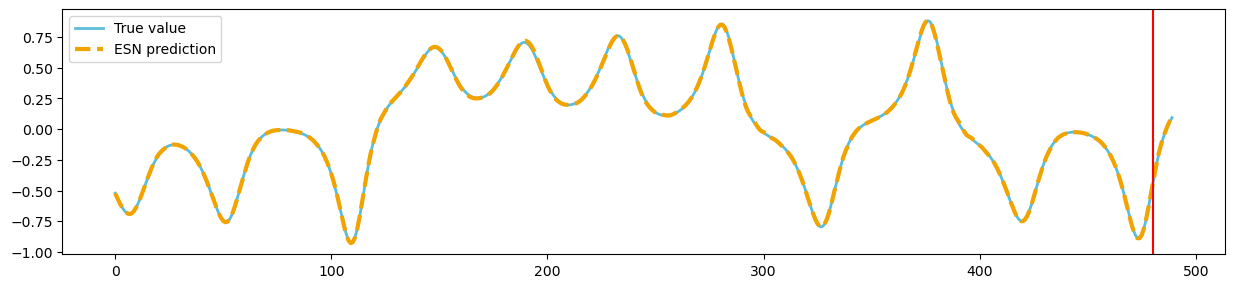

0.002973109900580481


C:\Users\nicks\AppData\Local\Temp\ipykernel_22264\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


In [126]:
#Первый тестовый набор параметров 
units = 830
leak_rate = 0.55
spectral_radius = 0.6
input_scaling = 3.
connectivity = 0.51
input_connectivity = 0.51
regularization = 1.e-08
seed = 1534



#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
print(rmse(y_pred1[-100:], X[-100:]))
###HERE1

In [ ]:
def hyp():
    for q in range(len(Units)):
        for w in range(len(Leak_rate)):
            for e in range(len(Spectral_radius)):
                for r in range(len(Input_scaling)):
                    for t in range(len(Connectivity)):
                        for z in range(len(Input_connectivity)):
                            for u in range(len(Regularization)):
                                for a in range(len(Seed)):
                                    #Первый тестовый набор параметров 
                                    units = Units[q]
                                    leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                    spectral_radius = Spectral_radius[e] #от 0.1 до 1
                                    input_scaling = Input_scaling[r]
                                    connectivity = Connectivity[t] #от 0 до 1
                                    input_connectivity = Input_connectivity[z] #тоже %
                                    regularization = Regularization[u]
                                    seed = Seed[a]

                                    #узел резервуара
                                    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                        lr=leak_rate, rc_connectivity=connectivity,
                                                        input_connectivity=input_connectivity, seed=seed)
                                    #выходной слой(считывающее устройство)
                                    readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                    #соединяем узлы и таким образом получаем модель 
                                    esn = reservoir >> readout

                                    #обучение модели
                                    esn = esn.fit(X_train1, y_train1)
                                    #делаем предсказание
                                    y_pred1 = esn.run(X_test1, reset=False)
                                    #results(y_pred1, X[train+forecast:])
                                    Rmse = rmse(y_pred1[-100:], X[-100:])
                                    if (Rmse<BestRmse):
                                        BestRmse = Rmse
                                        BestHyp[0] = Units[q]
                                        BestHyp[1] = Leak_rate[w]
                                        BestHyp[2] = Spectral_radius[e]
                                        BestHyp[3] = Input_scaling[r]
                                        BestHyp[4] = Connectivity[t]
                                        BestHyp[5] = Input_connectivity[z]
                                        BestHyp[6] = Regularization[u]
                                        BestHyp[7] = Seed[a]
                                    return BestRmse, BestHyp
